In [1]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt
from random import randrange
import sys

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten,Conv2D,Conv2DTranspose,Lambda,concatenate,GlobalMaxPooling2D,Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
#from keras.initializers.h as 
from tensorflow.python.keras.utils.vis_utils import plot_model
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2 
from pandas import read_excel
import pydot
from sklearn.metrics import confusion_matrix
#pip install xlrd
# apt install python-pydot python-pydot-ng graphviz

In [4]:
# !{sys.executable} -m pip install pydot
# !{sys.executable} -m pip install pydotplus
# !{sys.executable} -m pip install graphviz
#apt-get update
#apt install python-pydot python-pydot-ng graphviz
# apt install python3-sklearn 
!{sys.executable} -m pip install -U scikit-learn scipy

In [5]:
path_input_images =  '/tensorflow/IITD_Database/'

In [6]:
mask_path  = '/tensorflow/iit_unet/mask_data/'

In [7]:
# data = read_excel(data_in_labels_path, sheetname='Sheet1')

In [8]:
# data.head()

In [9]:
def change_name(name):
    d = name.split('/')
    mask_name = 'frame' + '_' + d[0]+'_'+d[1] +'.png'
    return mask_name


In [10]:
#rows = data[data['image_name']=='001_04.bmp']

In [11]:
#rows['Y1p'].iloc[0]

In [12]:
def read_simaese_parametric_data(path_input_images, folder_name_list_batch,batch_size):
    
    
    h  = 128
    w = 128
    
    factor  = 4
    
    train_out1 = np.zeros((factor*batch_size,h,w,3),'float')
    train_out2 = np.zeros((factor*batch_size,h,w,3),'float')
    
    out1= np.zeros((factor*batch_size,h,w,3),'float')
    out2= np.zeros((factor*batch_size,h,w,3),'float')
       
    pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
    pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

    neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
    #
    count = 0
    y = []
    
    for folder_name in folder_name_list_batch:
        for j in range (len(pos_comb1)-9):           
            i = random.randint(0, 9)
        
            ## read the image from folder in postive combination 
            #print('pos_combi =' + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            
            img1_0 = cv2.resize(img1_0,(h,w))
            img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
#             print('pos_combi =' + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
            img1_1 = cv2.resize(img1_1,(h,w))
            ##get the correspondance segmentation data 
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)

            
            ## save the image data to out and out2         
            out1[count]  = img1_0
            out2[count]  = img1_1

            
            #save the segmentation data to lable 

            
            ## posive combination assigning 0 to last clolumn
            y.append(1.0)
            
            ## increament the count
            count = count+1
            
            

            img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
            img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
            img2_0 = cv2.resize(img2_0,(h,w))
            img2_1 = cv2.resize(img2_1,(h,w))
            
            name1 = folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)

            out1[count]  = img2_0
            out2[count]  = img2_1      

            y.append(1.0)
            count = count+1

            
            ## negative combination left vs right iris for same person 
            folder_name2 = str(int(folder_name) + 1).zfill(3)
#             print('neg_combi =' + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
#             print('neg_combi =' + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_1 = cv2.imread(path_input_images + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
            img3_0 = cv2.resize(img3_0,(h,w))
            img3_1 = cv2.resize(img3_1,(h,w))
            
            name1 = folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)
           
            out1[count]  = img3_0
            out2[count]  = img3_1

            ## assigning 1 to negative combinations (left vs right image)
            y.append(0.0)
            count = count+1

            
            ## creating the negativ combination from diffrent person 
            folder_name1 = str(int(folder_name) + 3).zfill(3) 
            img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')

            img4_0 = cv2.resize(img4_0,(h,w))
            img4_1 = cv2.resize(img4_1,(h,w))
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)
            
            out1[count]  = img4_0
            out2[count]  = img4_1
            y.append(0.0)
            count = count+1
#             print(count)
            
    ## this padding the data set for size 256x512 to maintain spect rationa nd segmentation parameters 
    train_out1 = out1
    train_out2 = out2 
    
    
    return train_out1,train_out2,y
        #print(count) 

In [13]:
#print(np.array(list(product([2,3,4,5], [8,9,10]))))
print(np.array(list(combinations([1, 2, 3, 4, 5], 2))))


[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 3]
 [2 4]
 [2 5]
 [3 4]
 [3 5]
 [4 5]]


In [14]:
def imageLoader(path_input_images,folder_name_list,batch_size):

    L = len(folder_name_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

#         batch_start = randrange(L-batch_size)
#         batch_end = batch_start + batch_size
        batch_start = randrange(L-batch_size)
        batch_end = batch_start + batch_size
        if(batch_end < L):

            limit = min(batch_end, L)
            #print('batch_start =' , batch_start)
            train_out1,train_out2,y_class = read_simaese_parametric_data(path_input_images,folder_name_list[batch_start:limit],batch_size)
            train_out1 = train_out1/255.
            train_out2 = train_out2/255.
            batch_start = batch_end
            batch_end = batch_start + batch_size
            #print(batch_start,batch_end)
            ## just for the test 
            #yield (train_out2,train_seg2)
            ## original
            yield ([train_out1,train_out2],np.array(y_class)) #a tuple with two numpy arrays with batch_size samples     

In [15]:
folder_names = np.sort(os.listdir(path_input_images))
folder_name_list = folder_names[0:120] 
folder_name_list_test = folder_names[120:220]
print(len(folder_name_list_test))

100


### Function to check the GT and loader 

In [16]:
def draw_haugh_circle(img_L,img_R, hough_param):        
    
    
    print('pair_classification =', int(hough_param[12]))
    cimg = img_L.copy()
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),int(hough_param[2]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),int(hough_param[5]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),2,(0,0,255),3)
    plt.title('left_image')
    plt.imshow(cimg)
    plt.show()
    
    
    cimg = img_R.copy()
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),int(hough_param[8]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),int(hough_param[11]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),2,(0,0,255),3)
    plt.title('right_image')
    plt.imshow(cimg)
    plt.show()

In [18]:
g=0
while (g < 200):

    Out = next(imageLoader(path_input_images,folder_name_list_test,1))
    g = g+1


In [19]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]

# mask_L_R_class = Out[1]

# mask_L = mask_L_R_class[0]
# mask_R = mask_L_R_class[1]
# y = mask_L_R_class[2]
print(Out[1])
print(image_L.shape)

[1. 1. 0. 0.]
(4, 128, 128, 3)


# mask_L.shape

In [18]:
# plt.title('left_image')
# plt.imshow(image_R[1])
# plt.show()

In [19]:
# plt.title('left_mask')
# plt.imshow(np.squeeze(mask_R[1]))
# plt.show()

In [20]:
folder_names = np.sort(os.listdir(path_input_images))

print(folder_names[0:20])

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020']


In [21]:
# initialize_weights = 'he_normal'
# initialize_bias = 'he_normal'
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [22]:
# W_init = 'he_normal'
# b_init = 'he_normal'
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [23]:
def base_Siamese_model():
    """
        Model architecture
    """
    input = Input(shape=(128,128,3), name="base_input")
    c10 = Conv2D(64, (10,10), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))(input)
    p10 = MaxPooling2D()(c10)
    c11 = Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p10)
    p11 = MaxPooling2D()(c11)
    c12 = Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p11)
    p12 = MaxPooling2D()(c12)
    c13 = Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p12)
    a1 = Flatten()(c13)
    a2 = Dense(128, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(a1)  
    
    print("simaese model done")
    return Model(inputs=input, outputs=a2)
    

simaese model done


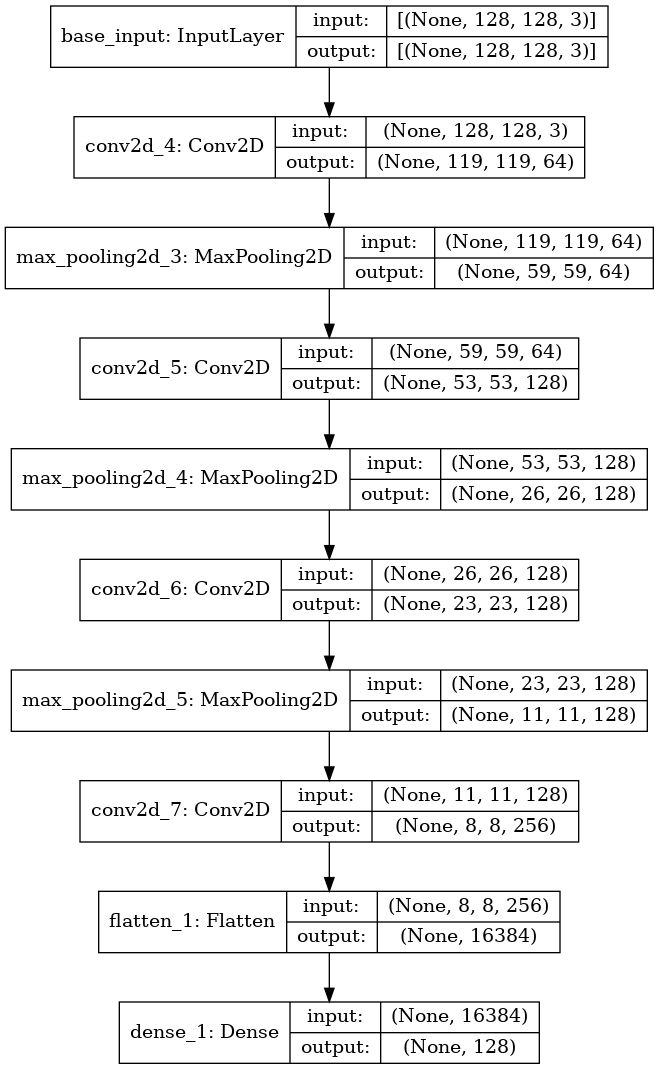

In [25]:
base_network = base_Siamese_model()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='saimes-model.png')

In [25]:
# base_network = base_network_unet_siamese()
# plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model_siamese.png')

In [26]:
# # create the left input and point to the base network
# input_a = Input(shape=(256,256,3), name="left_input")
# vect_output_a = base_network(input_a)

# # create the right input and point to the base network
# input_b = Input(shape=(256,256,3), name="right_input")
# vect_output_b = base_network(input_b)

# # measure the similarity of the two vector outputs
# output_siasmese = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# # specify the inputs and output of the model
# model = Model([input_a, input_b],output_siasmese)
# #plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model_simaese.png')

In [26]:
input_a = Input(shape=(128,128,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(128,128,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output_siasmese = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output_siasmese)

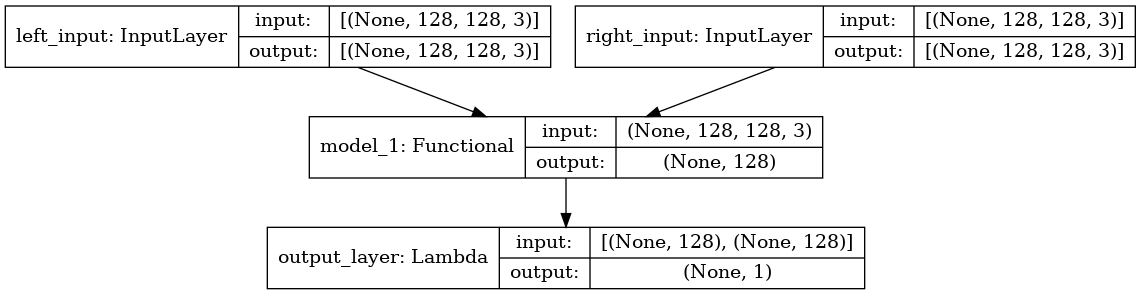

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model_simaese.png')

In [28]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [29]:
optimizer = tf.keras.optimizers.Adam(lr = 0.00001)


#siamese_model.compile(loss=custom_loss, optimizer=optimizer, metrics = ['mae', 'acc'])
model.compile(loss = contrastive_loss_with_margin(margin=1)
                     ,optimizer=optimizer, metrics = ['mae', 'acc'])

In [30]:
#steps_per_epoch = train_length // batch_size
batch_size = 1
steps_per_epoch = len(folder_name_list) // batch_size
validation_steps = len(folder_name_list_test) // batch_size

In [31]:

# history = siamese_model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
#                     validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
#                     validation_steps=validation_steps, epochs=50)

In [32]:
history = model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
                    validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
                    validation_steps=validation_steps, epochs=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
120/120 [==============================] - 53s 438ms/step - loss: 1.0750 - mae: 1.1169 - acc: 0.4557 - val_loss: 0.6629 - val_mae: 0.7319 - val_acc: 0.3175
Epoch 2/50
120/120 [==============================] - 52s 431ms/step - loss: 0.6780 - mae: 0.7417 - acc: 0.3111 - val_loss: 0.5867 - val_mae: 0.6942 - val_acc: 0.1525
Epoch 3/50
120/120 [==============================] - 52s 431ms/step - loss: 0.5765 - mae: 0.7387 - acc: 0.1439 - val_loss: 0.5618 - val_mae: 0.7093 - val_acc: 0.1300
Epoch 4/50
120/120 [==============================] - 52s 431ms/step - loss: 0.5669 - mae: 0.7281 - acc: 0.1486 - val_loss: 0.5455 - val_mae: 0.7139 - val_acc: 0.1175
Epoch 5/50
120/120 [==============================] - 52s 431ms/step - loss: 0.5344 - mae: 0.7559 - acc: 0.1146 - val_loss: 0.5307 - val_mae: 0.7198 - val_acc: 0.1000
Epoch 6/50
120/120 [==============================] - 52s 435ms/step - loss: 0.5002 - mae: 0.8105 - acc: 0.0626 - val_loss: 0.5164 - val_mae: 0.7294 - val_acc: 0.092

In [33]:
print(tf.keras.__version__)

2.4.0


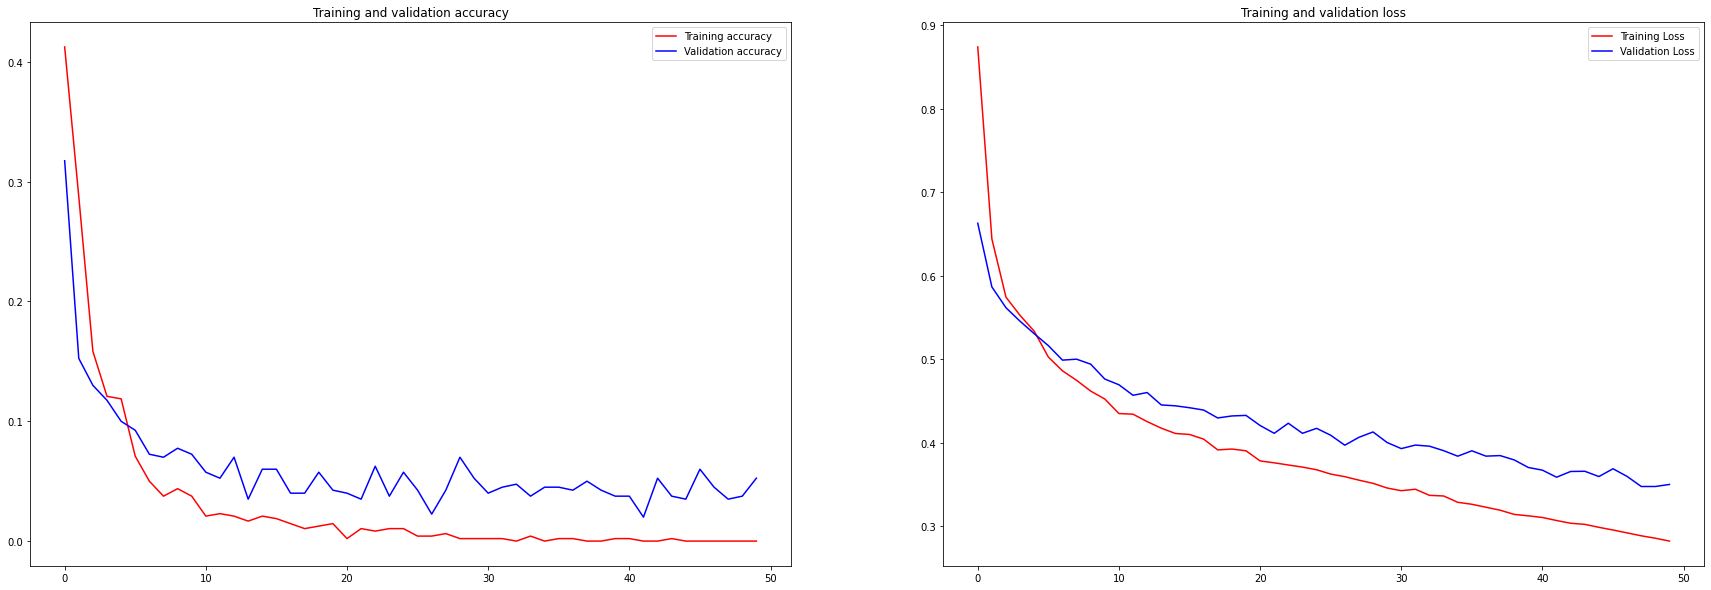

In [34]:
import matplotlib.pyplot as plt
# Let's take a look at how we did during training.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

# Loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [35]:
model_save_path = '/tensorflow/siamese_model/siamese_constructive_loss_128_epoch50_test100.h5'
model.save(model_save_path)

In [36]:
model = load_model(model_save_path,custom_objects={'contrastive_loss':contrastive_loss_with_margin(margin=1)})

In [37]:
Out = next((imageLoader(path_input_images,folder_name_list_test,1)))

In [38]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]


y = Out[1]
print(y)
print(image_L.shape)
#plt.title('left_mask')
#plt.imshow(np.squeeze(mask_R[1]))
#plt.imshow(image_R[1])
#plt.show()

[1. 1. 0. 0.]
(4, 128, 128, 3)


In [39]:
preds = model.predict([image_L,image_R])



print(preds[1])

[0.17743874]


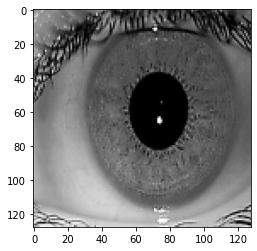

In [40]:

#plt.imshow(np.squeeze(mask_R[1]))
plt.imshow(image_R[1])
plt.show()

In [28]:
# out_image = np.squeeze(preds[1][1])
# preds[0].shape

In [ ]:

# dummy_image = image_R[1].copy() 
# dummy_image[out_image<.5] = 0
# plt.imshow(dummy_image)
# plt.show()

In [ ]:
# y = preds[2]
# print(y)

In [ ]:
## Test data for model 

In [42]:
test_out1,test_out2,y_true = read_simaese_parametric_data(path_input_images,folder_name_list_test[0:100],100)

In [43]:
test_out1 = test_out1/255.0
test_out2 = test_out2/255.0

In [44]:
y_pred = model.predict([test_out1,test_out2])

In [45]:
print(y_pred.shape)
print(test_out1.shape)

(400, 1)
(400, 128, 128, 3)


In [46]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [47]:
compute_accuracy(y_true, y_pred)

0.9575

In [48]:
confusion_matrix(y_true, y_pred.ravel() < 0.5)                             ##   [TN , FP]
                                                                           ##    [FN , TP]   

array([[188,  12],
       [  5, 195]])